In [1]:
# using DifferentialEquations
using PhysicalConstants.CODATA2018
using PyPlot
using Random
using OrdinaryDiffEq
using RecursiveArrayTools
# using ArrayFire
# af = ArrayFire

In [14]:
#### This is a code trying to generate the molecular dynamics of gas molecules in a trapped volume #####

kb = BoltzmannConstant.val
## parameters for the LJ potential
ϵ = 1.65e-21 # in Joules
σ = 3.4e-10 # in meters
m = 6.69e-26 # mass of the atom in KG

#### constants for dimensionless parameters
τ = sqrt(m*σ^2/ϵ) ## time
r0 = σ
v0 = r0/τ

N = 20 # number of atoms
f0 = ϵ/σ # force
P0 = ϵ/σ^3 # pressure
T0 = ϵ/kb
l = 5 # length of the box in uinits of σ
r_cut = 10 # cut_off radius in units of σ

# function to make a grid
flat_gridpoints(grids) = vec(collect(Iterators.product(grids...)))

# defining the positions of the atoms, in units of sigma
function initiate(N)
    a = range(-0.99*l,stop=0.99*l,length=convert(Int64,ceil(sqrt(N)))+1)
    req = flat_gridpoints((a,a,a))
    req=[[x for x in i] for i in req]
    final=req[1]
    for i in req[2:end]
        final=hcat(final,i)
    end
    grid = (transpose(final))
    
    x = shuffle(grid[:,1])[1:N]
    y = shuffle(grid[:,2])[1:N]
    z = shuffle(grid[:,3])[1:N]

    # defining the velocities of the atoms, in units of σ/τ
    vx = (2 .*randn(N).-1).*0.5
    vy = (2 .*randn(N).-1).*0.5
    vz = (2 .*randn(N).-1).*0.5
#     ## the following are used to test two particles head on; uncomment the following lines to enable it and set N=2
#     x = x.*0
#     y = [0,0]#y.*0
#     z = [-0.75,0.75].*l
#     vx = vx.*0
#     vy = [0,0]#vy.*0
#     vz = [0.5,-0.5]
#     ## done with test conditions
    
    pos = hcat(x,y,z)
    vel = hcat(vx,vy,vz)
    vel = vel .- sum(vel)/(3*N)
    
    return pos,vel
end

initiate (generic function with 2 methods)

In [7]:
# defining the functions necessary for the system; required are force, potential energy, kinetic energy

function E_pot(pos,n1,n2) # defining the potential energy between two atoms
    r = sqrt(sum(@. abs(pos[n1,:] - pos[n2,:])^2))
    if n1==n2 # cutoff radius
        return 0
    end
    return 4*((1/r)^12 - (1/r)^6)
end

function Potential_Energy(pos)
    pot = 0
    for n1=1:N
        for n2=1:N
            if n2>n1 
                pot += E_pot(pos,n1,n2)
            end
        end
    end
    return pot
end

function Kinetic_Energy(vel) # kinetic energy of the entire system
    return sum(vel.^2)*0.5
end

Temperature(vel) = (2*Kinetic_Energy(vel)/(3*N-3))*(T0)

function force(pos,n1,n2)
    vec = pos[n1,:] .- pos[n2,:]
    if n1==n2 # implementing cutoff radius and avoiding force calculation from the same atom
        return vec.*0
    end
    r = sqrt(sum(@. abs(vec)^2))
    if r > r_cut
        return vec.*0
    end
    return (48/r^2)*((1/r)^12 - 0.5*(1/r)^6).*vec
end

function force_T(pos)
    force_mat = pos.*0
    for n1=1:N
        f = pos[1,:].*0
        for n2=1:N
            f = f.+ force(pos,n1,n2)
        end
        force_mat[n1,:] = f
    end
    return force_mat
end

force_T (generic function with 1 method)

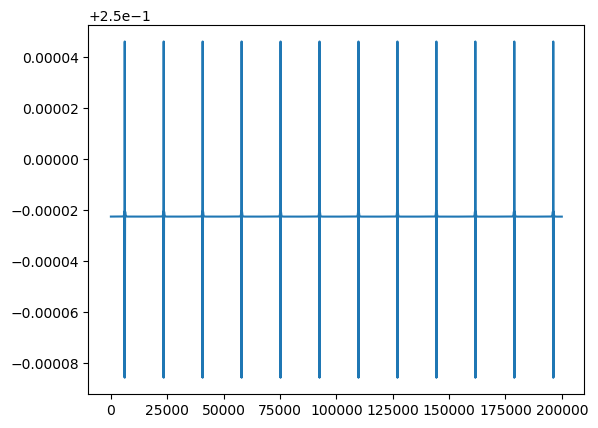

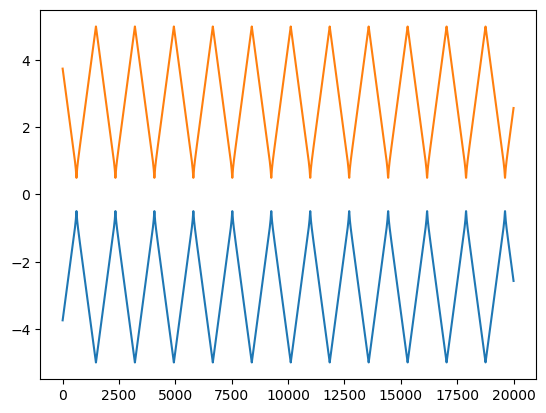

  6.060341 seconds (21.68 M allocations: 1.174 GiB, 7.88% gc time)


In [145]:
#### This is a code trying to generate the molecular dynamics of gas molecules in a trapped volume #####

N = 2 # number of atoms

dt = 1e-3
#### This block implements the Velocity-Verlet algorithm using a manually written for-loop 
@time begin

N = 2
pos,vel = initiate(N)
f_i = force_T(pos)

pos_list = []
KE=[]
PE=[]
for i=1:200000
    global vel, pos, f_i
    v_h = vel + 0.5*dt*f_i
    pos = pos + v_h*dt
    f = force_T(pos)
    vel = v_h + 0.5*dt*f
    f_i = f
    # boundary conditions
    while sum([abs(x) > l for x in pos]) > 0
        atoms_crossed=findall(x->abs(x)>l,pos)
        atoms_crossed=map(x->[x.I...],atoms_crossed)
        for i in atoms_crossed
            atom = pos[i[1],i[2]]
#             pos[i[1],i[2]] = atom - 2*l*sign(atom) # periodic boundary condition
            pos[i[1],i[2]] = sign(atom)*l + sign(-atom)*(abs(atom)-l)# reflective boundary condition
            vel[i[1],i[2]] = -vel[i[1],i[2]]*1.00
        end
    end
    if sum([abs(x) > 2*l for x in pos]) > 0
        break
    end
    # done boundary conditions
    
    # collecting parameters
    if i%10==0 # collecting positions every 10 steps
        append!(pos_list,pos)
    end
    append!(KE,Kinetic_Energy(vel))
    append!(PE,+Potential_Energy(pos))
end
#     end # end to time measurement
    
figure()
plot(KE+PE)

end

function atom_traj(n,pos_list)
    (leng,) = size(pos_list)
    data_pts = convert(Int64,leng/(N*3))
    pos_n=zeros(data_pts,3)
    for i=1:data_pts
        pos_n[i,1] = pos_list[3*N*(i-1)+n]
        pos_n[i,2] = pos_list[3*N*(i-1)+n+N]
        pos_n[i,3] = pos_list[3*N*(i-1)+n+2*N]
    end
    return pos_n
end
figure()
for i=1:N # chose the atoms whose trajectory you want to plot
plot(atom_traj(i,pos_list)[:,3])
end
#### Manually written for loop done ###

In [16]:
#### This block uses the solver and a higher order symplectic solver to integrate the equations ##

### setting the parameters ###
N=20

ξ = 0
# ξ_list=[]
α = 0.5e-4
T_set = 373 # in Kelvin

dt = 0.0005
t_step = dt*25
t_span = (0.0,400)
####

@time begin
    
pos,vel = initiate(N)
    
while isnan(Potential_Energy(pos))
    global pos,vel
    pos,vel = initiate()
end
# sys_init = vcat(pos,vel)
    
function F(v,u,p,t)
    global ξ
    T = Temperature(v)
    ξ += -1e-3*ξ + α*(T - T_set*(3*N+1-3)/(3*N-3))*t_step*0.5
#     append!(ξ_list,ξ)
    dv = force_T(u) .- ξ.*v
    return dv
end

######### implementing the continuous boundary condition using ContinuousCallback
# using an integrator to connect with the solver   
condition(u,t,integrator) = sum([abs(x) > l for x in integrator.u.x[2]]) > 0

function affect!(integrator)
    pos=integrator.u.x[2]
    vel=integrator.u.x[1]
    friction = integrator.u.x[2][end,:]
    atoms_crossed=findall(x->abs(x)>l,pos)
    atoms_crossed=map(x->[x.I...],atoms_crossed)
    for i in atoms_crossed
        atom = pos[i[1],i[2]]
#         pos[i[1],i[2]] = atom - 2*l*sign(atom) # periodic boundary condition
        pos[i[1],i[2]] = sign(atom)*l + sign(-atom)*(abs(atom)-l) # reflective boundary condition
        vel[i[1],i[2]] = -vel[i[1],i[2]]
    end
    if sum([abs(x) > 2*l for x in pos]) > 0
        println("Solution exploded!!")
        terminate!(integrator)
    end
    integrator.u = ArrayPartition(vel,pos)
end
    
cb = DiscreteCallback(condition,affect!)

problem = SecondOrderODEProblem{false}(F,vel,pos,t_span,callback=cb)

sol = solve(problem,VelocityVerlet(),dt=t_step);
println("Done")
run(`notify-send "Simulation Done" --icon="/usr/share/icons/Yaru/32x32/emblems/emblem-default.png"`);
end

Done
 57.193991 seconds (306.00 M allocations: 21.222 GiB, 8.39% gc time)


Process(`notify-send 'Simulation Done' --icon=/usr/share/icons/Yaru/32x32/emblems/emblem-default.png`, ProcessExited(0))

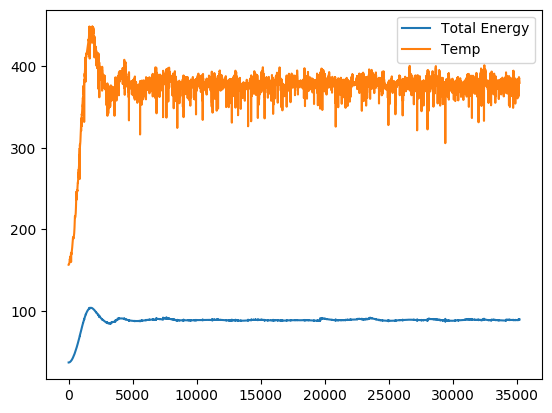

In [17]:
# # plotting the solution
t = sol.t
(leng,)=size(t)

E=[]
T = []
for i=1:leng
    append!(E,Kinetic_Energy(sol.u[i].x[1])+Potential_Energy(sol.u[i].x[2]))
    append!(T,Temperature(sol.u[i].x[1]))
end
plot(E,label="Total Energy")
plot(T,label="Temp")
legend()
show()